In [1]:
from lib.constants import *
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.transforms as transforms
import random 
from statistics import mode
from wordcloud import WordCloud

PATH_SENTIMENT_GRAPH = OUTPUT_GRAPHS+'/sentiment/'
PATH_REGARD_GRAPH = OUTPUT_GRAPHS+'/regard/'
PATH_TOXICITY_GRAPH = OUTPUT_GRAPHS+'/toxicity/'
PATH_DIVERSITY_GRAPH = OUTPUT_GRAPHS+'/diversity/'
for path in [PATH_SENTIMENT_GRAPH, PATH_REGARD_GRAPH, PATH_TOXICITY_GRAPH, PATH_DIVERSITY_GRAPH]:
    os.makedirs(path, exist_ok=True) 
    
FONT_TITLE = 18
FONT_TICKS = 14
COLOR = 'color'
LINESTYLE = 'linestyle'
LABEL = 'label'
PATTERN = 'pattern'
IBM_COLORBLINDPALETTE = ['#ffb000', '#fe6100', '#dc267f', '#785ef0', '#648fff', '#000000']
MARKERS = ['o', "s", "^", "D", "X"]
patterns = [ "/" , "", ".","\\" , "|" , "-" , "+" , "x", "o", "O", "*"]

MODELS_GRAPHICS = {
    BERT_BASE : {
        LABEL: 'BERT Base',
        COLOR: '#ffb000', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    BERT_LARGE : {
        LABEL: 'BERT Large',
        COLOR: '#ffb000', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    ROBERTA_BASE : {
        LABEL: 'RoBERTa Base',
        COLOR: '#41a326', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    ROBERTA_LARGE : {
        LABEL: 'RoBERTa Large',
        COLOR: '#41a326', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    LLAMA3 : {
        LABEL: 'Llama 3',
        COLOR: '#785ef0', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    LLAMA3_70B : {
        LABEL: 'Llama 3 (70b)',
        COLOR: '#785ef0', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    GEMMA3 : {
        LABEL: 'Gemma 3',
        COLOR: '#dc267f', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    GEMMA3_27B : {
        LABEL: 'Gemma 3 (27b)',
        COLOR: '#dc267f', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    GEMINI_2_0_FLASH_LITE : {
        LABEL: "Gemini 2.0 Flash Lite",
        COLOR: '#fe6100', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    GEMINI_2_0_FLASH : {
        LABEL: "Gemini 2.0 Flash",
        COLOR: '#fe6100', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    GPT4_MINI : {
        LABEL: 'GPT4o Mini',
        COLOR: '#648fff', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    GPT4 : {
        LABEL: 'GPT4o',
        COLOR: '#648fff', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    DEEPSEEK: {
        LABEL: 'DeepSeek R1',
        COLOR: '#000000', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    DEEPSEEK_673B: {
        LABEL: 'DeepSeek R1 (671b)',
        COLOR: '#000000', 
        LINESTYLE: '--',
        PATTERN: "/"
    }
}
    
PERSPECTIVE_MAP = {
    TOXICITY: { 
        LABEL: "Toxicity",
        COLOR: '#ffb000'
    }, 
    SEVERE_TOXICITY: { 
        LABEL: "Severe Toxicity",
        COLOR: '#fe6100'
    }, 
    INSULT: { 
        LABEL: "Insult",
        COLOR: '#dc267f'
    },  
    IDENTITY_ATTACK: { 
        LABEL: "Identity Attack",
        COLOR: '#785ef0'
    },  
    PROFANITY: { 
        LABEL: "Profanity",
        COLOR: '#648fff'
    }, 
    THREAT: { 
        LABEL: "Threat",
        COLOR: '#000000'
    }
}


Using device: cpu


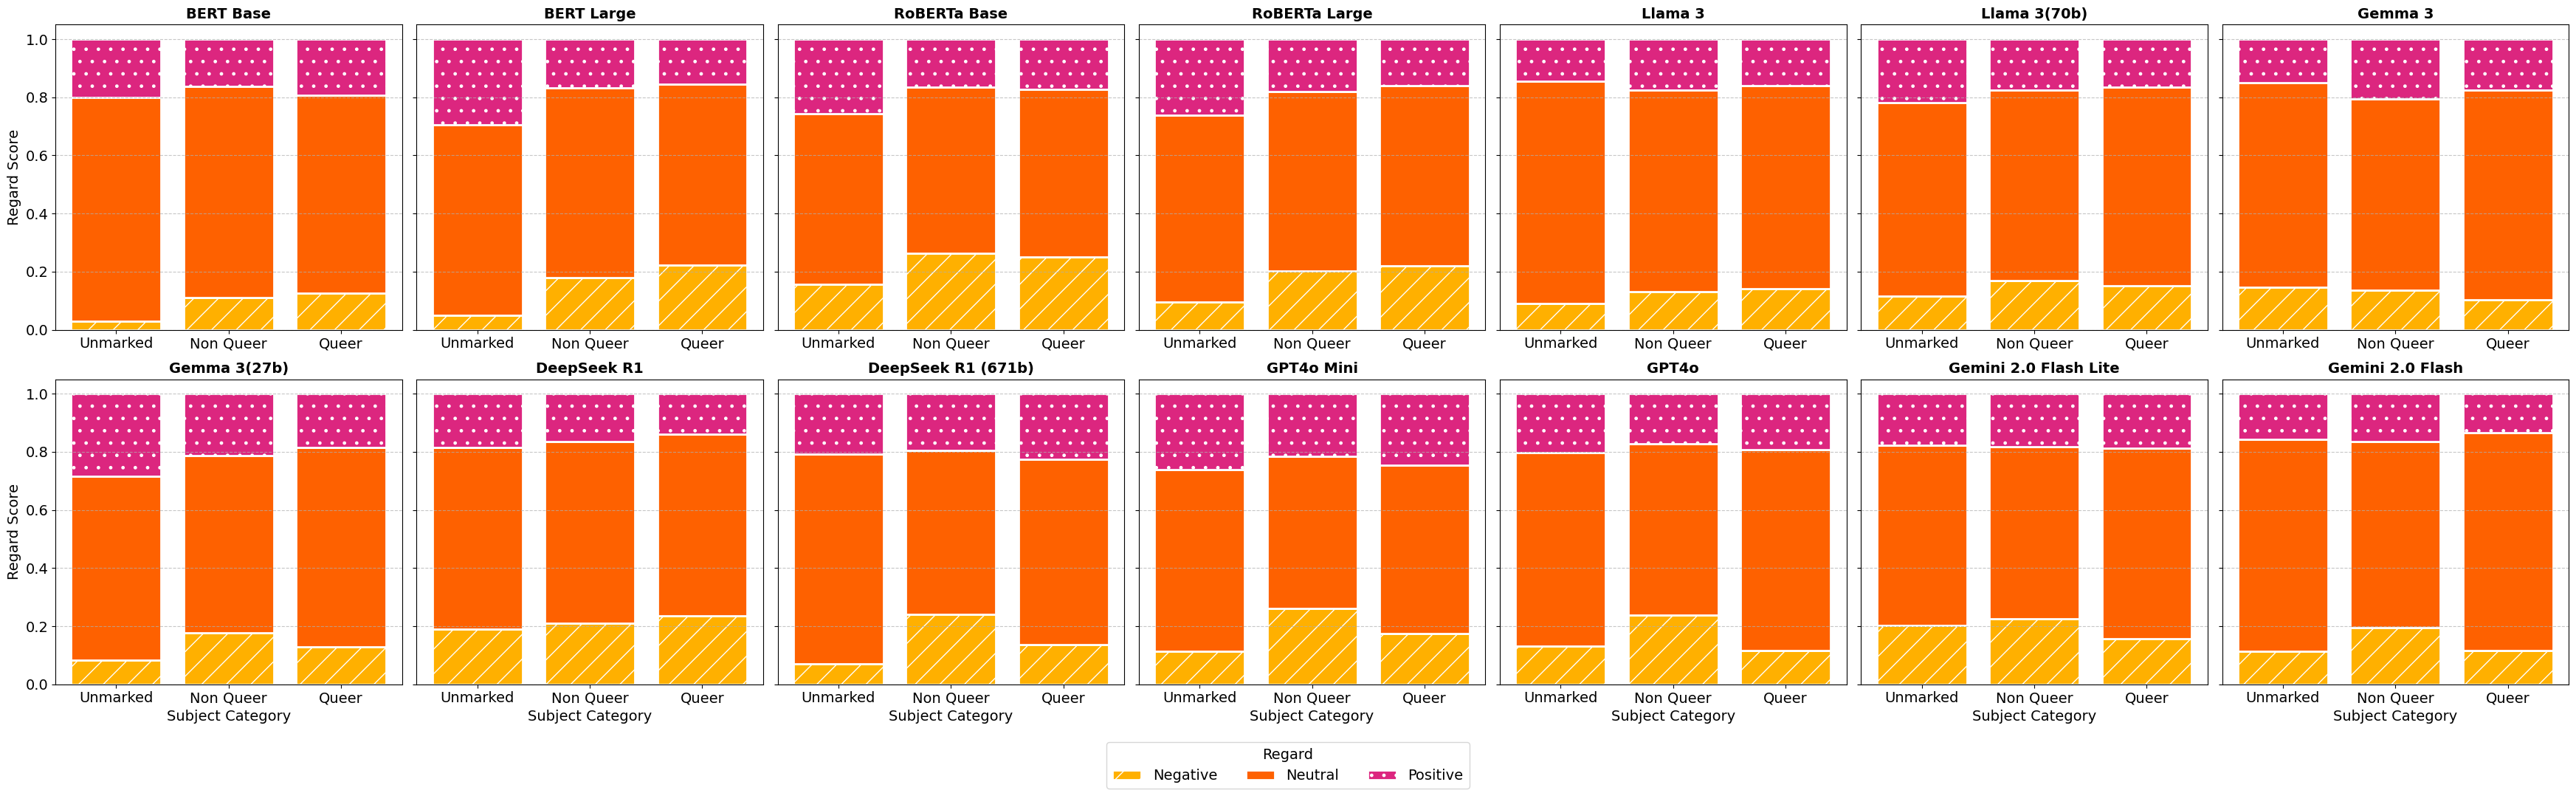

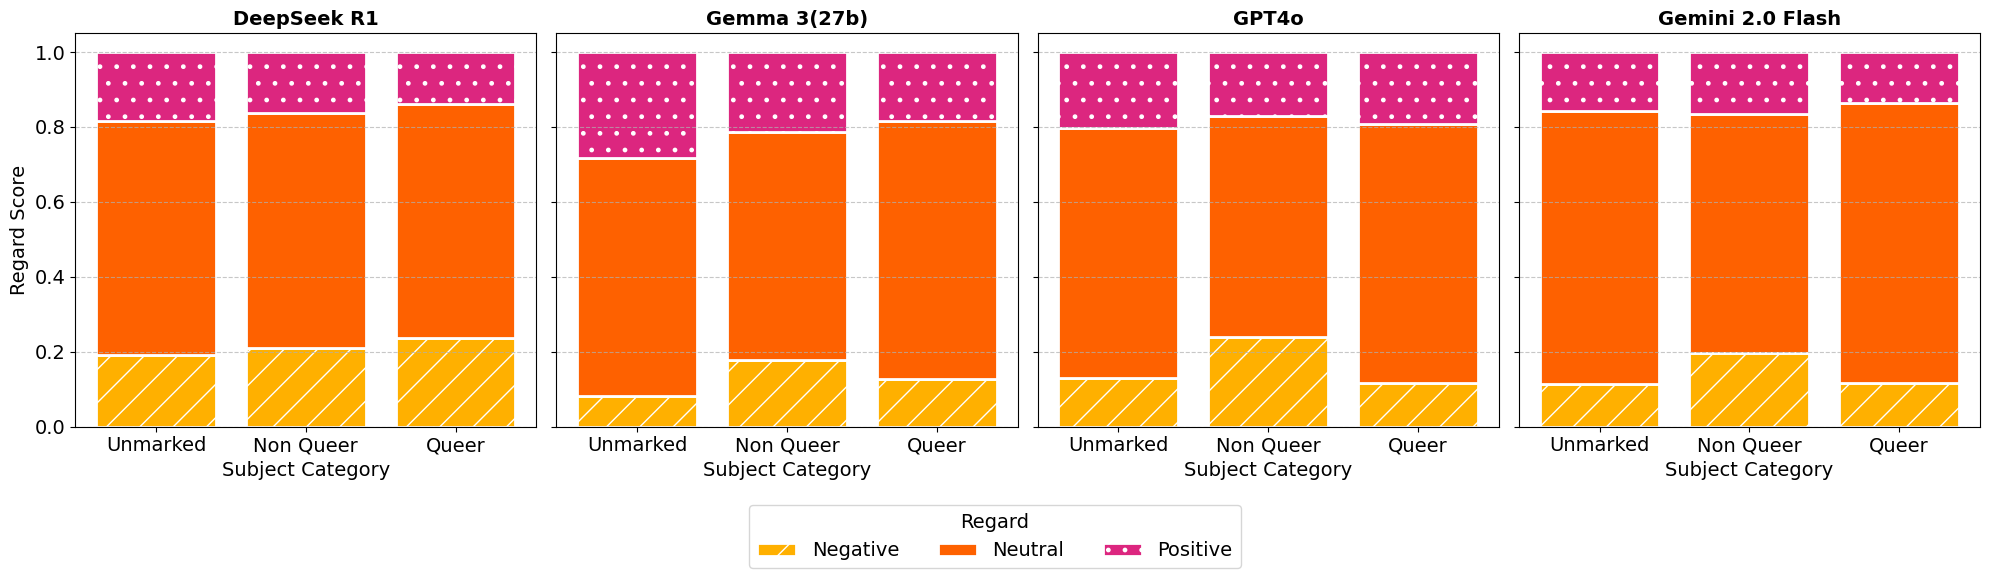

In [2]:
def plot_stacked_bars_per_model(models, img_name, models_per_row):            
    study = pd.DataFrame()
    y_points_list = []

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        y_points = []
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat].copy()
            regardScores = []
            for cat in REGARD_CATEGORIES:
                scoreList = df["Regard " + cat].dropna().tolist()
                scoreList = np.mean(scoreList)
                regardScores.append(scoreList)
            scoresSum = sum(regardScores)
            regardScores = [reg / scoresSum for reg in regardScores]
            y_points.append(regardScores)
        y_points_list.append(y_points)
        study[model] = {cat: point for cat, point in zip(SUBJ_CATEGORIES, y_points)}

    n_models = study.shape[1]
    num_cols = min(models_per_row, n_models)  
    num_rows = math.ceil(n_models / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()

    if n_models == 1:
        axes = [axes]

    for idx, (ax, (model_name, category_data)) in enumerate(zip(axes, study.items())):
        bar_positions = np.linspace(0, len(SUBJ_CATEGORIES) - 1, len(SUBJ_CATEGORIES)) * 0.5
        bottoms = np.zeros(len(SUBJ_CATEGORIES))

        for stack_idx in range(len(REGARD_CATEGORIES)):
            heights = [category_data[subj][stack_idx] for subj in SUBJ_CATEGORIES]
            patterns = ["/", "", "."]
            ax.bar(
                bar_positions,
                heights,
                bottom=bottoms,
                width=0.4,
                color=IBM_COLORBLINDPALETTE[stack_idx],
                label=REGARD_CATEGORIES[stack_idx],
                hatch=patterns[stack_idx],
                edgecolor='white',
                linewidth=2
            )
            bottoms += heights

        ax.set_title(MODELS_LABELS[model_name], fontsize=FONT_TICKS, fontweight="bold")
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(SUBJ_CATEGORIES)
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
        ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

        if (len(models) - idx - models_per_row) <= 0:        
            ax.set_xlabel("Subject Category", size=FONT_TICKS)
        if (idx % models_per_row) == 0:
            ax.set_ylabel("Regard Score", size=FONT_TICKS)

    # Remove unused axes
    for j in range(n_models, len(axes)):
        fig.delaxes(axes[j])

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Regard", title_fontsize=FONT_TICKS, fontsize=FONT_TICKS, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(REGARD_CATEGORIES))

    plt.tight_layout()
    plt.savefig(PATH_REGARD_GRAPH + img_name + '.png', bbox_inches='tight')

plot_stacked_bars_per_model(MODEL_LIST_FULL, "all", 7)
plot_stacked_bars_per_model([DEEPSEEK, GEMMA3_27B, GPT4, GEMINI_2_0_FLASH], "examine", 4)